# Riemannian 1-bit matrix completion and factorization

* Let our data be an adjancy matrix $A$ of a non-directed graph with $n$ vertices.


* Introduce $M_{uv}$ - the value determining the probability of an edge between $u, v$.
$$p(u,v) = 1 - \exp( - M_{uv}),$$
where $M$ is a symmetric matrix $M = M^T$.

* We can write the likelihood of our data:
$$
    l(M) = \sum_{(u,v)\in E} \log(1 - \exp(- M_{uv})) - \sum_{(u,v) \notin E} M_{uv} \rightarrow \max_{M_{uv} \ge 0, M = M^T}.
$$

* In order to proceed and make the estimation problem feasible we need to impose certain restrictions on matrix $M_{uv}$. One possible approach is to assume that matrix $M$ is low rank: $rank{M} \le k$ with $k << n$. The respective optimization problem is
$$
    l(M) = \sum_{(u,v)\in E} \log(1 - \exp(- M_{uv})) - \sum_{(u,v) \notin E} M_{uv} \rightarrow \max_{M_{uv} \ge 0, M = M^T, rank{M} \le k}.
$$

* Ideally, we would like to solve directly this problem, but the alternative can be in considering fixed-rank situation $rank{M} = k$ leading to the problem
$$
    l(M) = \sum_{(u,v)\in E} \log(1 - \exp(- M_{uv})) - \sum_{(u,v) \notin E} M_{uv} \rightarrow \max_{M_{uv} \ge 0, M = M^T, rank{M} = k},
$$
which is an optimization on the Riemannian manifold.

* Afterwards we can decompose the solution as a product: $ M = F F^T$, where $F \in \mathbb{R}^{n \times k}$ and consider rows of $F$ as community membership weights.
 

## Questions

1) What are peculiarities of the manifold $rank M = k$ under additional constraints  $M_{uv} \ge 0$ and $M = M^T$?

2) What is the complexity of usual Riemannian optimization methods? Can we make them more scalable?

3) What we can say about decomposition $M = F F^T$ in case when $rank{M} = k$, $M_{uv} \ge 0$ and $F \in \mathbb{R}^{n \times k}$? Can we make $F_{uv} \ge 0$?

4) This model is also suitable for matrix completion if we consider general $M \in \mathbb{R}^{n \times m}$, $M_{uv} \ge 0$ and we observe certain binary outcomes $a_{uv} \in \{0, 1\}$ for some subset of pairs $(u, v) \in S \subseteq \{1, \dots, n\} \times \{1, \dots, m\}$.

5) We can consider some other variants of imposing structure on $M$:

- sparse matrix;
- matrix generated from graphon;
- Eucledian distance matrix;
- ... .

# Straightforward approach

Let's build primitive Adjacency matrix factorisation approach

In [29]:
import numpy as np
import scipy as sp
from theano import *
import theano.tensor as T
from theano import grad
from theano import function
from pymanopt.manifolds import FixedRankEmbedded, PSDFixedRank
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent, ConjugateGradient, NelderMead
from math import isnan
# import imageio
from scipy.sparse.linalg import eigsh
from IPython.display import Image
from log_progress import log_progress

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white")

In [31]:
def test_example():
    return np.array([[0, 1, 1, 1, 0, 0, 0],
                     [1, 0, 1, 1, 0, 0, 0],
                     [1, 1, 0, 1, 0, 0, 0],
                     [1, 1, 1, 0, 1, 1, 1],
                     [0, 0, 0, 1, 0, 1, 1],
                     [0, 0, 0, 1, 1, 0, 1],
                     [0, 0, 0, 1, 1, 1, 0]])

def test_example3():
    return np.array([[0, 1, 0],
                     [1, 0, 1],
                     [0, 1, 0]])

In [32]:
eps_forse = 1e-8

U, V = T.dmatrices('U','V')
S = T.dvector('S')
A = U.dot(T.diag(S)).dot(V) # optimize

A = shared(test_example()) # adjacency matrix of graph
not_A = 1 - A - np.eye(7) # adjacency matrix of A^C
U_cut = T.maximum(0, U) # (???)
V_cut = T.maximum(0, V) # (???)
FF_est = U.dot(T.diag(S)).dot(V) # USV
FF_est_cut = U_cut.dot(T.diag(S)).dot(V_cut) # cutted USV (???)
P = 1 - T.exp(-FF_est - eps_forse)
logP = T.log(P)

llh = T.sum(logP * A) - T.sum(not_A * FF_est) # likelihood of our data
llh_grad = T.grad(llh, [U, S, V]) # gradient of likelihood function

C = 0.001
pen = C * T.sum(T.exp(-U))

loglikelihood = function([U, S, V], llh)
loglikelihood_grad = function([U, S, V], llh_grad)
loglikelihood_grad_M = T.grad(llh, FF_est)
A_est = function([U, S, V], P)

# Quadratic model

In [33]:
P2 = FF_est - A

se = -T.sum(P2*P2)
se_grad = T.grad(se, [U, S, V])
se_grad_M = T.grad(se, FF_est)

square_err = function([U, S, V], se)
square_err_grad = function([U, S, V], se_grad)
square_err_grad_M = function([U, S, V], se_grad_M)

A2_est = function([U, S, V], P2)

In [34]:
from collections import namedtuple

krankproj = namedtuple('krankproj', field_names=['Vp', 'M', 'Up'])

In [35]:
def init():
    n=7
    U_init = np.random.rand(n,2)
    #U_init = np.array([[1,1,1,1,0,0,0],
    #                   [0,0,0,1,1,1,1]]).T + np.random.rand(n,2) * 0.2
    S_init = np.random.rand(2)
    if S_init[0] < S_init[1]:
        S_init[0], S_init[1] = S_init[1], S_init[0]
    V_init = U_init.T
    
    return (U_init, S_init, V_init)


def man_norm(d):
    Ud, Sd, Vd = d
    
    return np.sqrt((np.sum(Ud*Ud) + np.sum(Sd* Sd) + np.sum(Vd* Vd)))


def proj(X, alpha, d):
    zero_cut=False
    #U, S, V = X[0] + alpha * d[0], X[1] + alpha * d[1], X[2] + alpha * d[2]
    newX = np.dot(X[0], np.dot(np.diag(X[1]), X[2])) + alpha * (X[0].dot(d.M.dot(X[2])) + d.Up.dot(X[2]) +
            X[0].dot(d.Vp.T))
    #np.dot(d[0], np.dot(np.diag(d[1]), d[2]))
    Un, Sn, Vn = np.linalg.svd(newX)
    if zero_cut:
        Un[Un<1e-6] = 1e-6
        Sn[Sn<1e-6] = 1e-6
        Vn[Vn<1e-6] = 1e-6
    return Un[:, :2], Sn[:2], Vn[:2]

def proj_M(X, Z):
    if isinstance(Z, tuple) or isinstance(Z, list):
        Z = Z[0].dot(np.diag(Z[1])).dot(Z[2])
    #print(Z)
    ZV = Z.dot(X[2].T)
    UtZV = X[0].T.dot(ZV)
    ZtU = Z.T.dot(X[0])
    Zproj = krankproj(
        M=UtZV,
        Vp=ZV - X[0].dot(UtZV),
        Up=ZtU - X[2].T.dot(UtZV.T))
    return Zproj

In [36]:
np.random.seed(1123)
X = init()
#d = init()

def py2mat(X):
    templ = "x.Up = [{}];\n\nx.M = [{}]';\n\nx.Vp = [{}]';\n\n"
    ss = []
    for k in range(len(X)):
        s = []
        for x in X[k]:
            try:
                s.append(', '.join(str(h) for h in x))
            except:
                s.append(str(x))
        s = ';\n      '.join(s)
        ss.append(s)
    return templ.format(*ss)

print(py2mat(X))
#print(py2mat(d))
#print(proj(X, 1, d))
#print()
#print(proj_M(X, d))

x.Up = [0.314408204725, 0.924562998917;
      0.418908136364, 0.0567832166507;
      0.638411017922, 0.0937655989925;
      0.515245531199, 0.645743428542;
      0.353656536597, 0.238034869386;
      0.847305079228, 0.120770107562;
      0.91308702203, 0.398184318986];

x.M = [0.789504411938;
      0.0700342046044]';

x.Vp = [0.314408204725, 0.418908136364, 0.638411017922, 0.515245531199, 0.353656536597, 0.847305079228, 0.91308702203;
      0.924562998917, 0.0567832166507, 0.0937655989925, 0.645743428542, 0.238034869386, 0.120770107562, 0.398184318986]';




In [37]:
def search(objective, x, d, f0, df0, old_alpha=None):
        """
        Function to perform backtracking line-search.
        Arguments:
            - objective
                objective function to optimise
            - manifold
                manifold to optimise over
            - x
                starting point on the manifold
            - d
                tangent vector at x (descent direction)
            - df0
                directional derivative at x along d
        Returns:
            - stepsize
                norm of the vector retracted to reach newx from x
            - newx
                next iterate suggested by the line-search
        """
        #Compute the norm of the search direction
        norm_d = man_norm(d)
        
        if old_alpha is None or old_alpha*norm_d <= 1e-10:
            alpha = 1 / norm_d
            alpha = float(alpha)
        else:
            alpha = 2 * old_alpha
        
        # Make the chosen step and compute the cost there.
        try:
            newx = proj(x, alpha, d)
            newf = objective(*newx)
        except sp.linalg.LinAlgError as e:
            newx = float('nan')
            newf = float('nan')
        step_count = 1
        suff_decr=1e-4
        maxiter=25
        contraction_factor=0.5
        # Backtrack while the Armijo criterion is not satisfied
        while (((newf < f0 + suff_decr * alpha * df0) or isnan(newf)) and
            step_count <= maxiter):

            # Reduce the step size
            alpha = contraction_factor * alpha
            try:
                # and look closer down the line
                newx = proj(x, alpha, d)
                newf = objective(*newx)
            except sp.linalg.LinAlgError as e:
                pass
            
            step_count = step_count + 1
            
        
        # If we got here without obtaining a decrease, we reject the step.
        if newf < f0:
            #print('!', end=' ')
            alpha = 0.00001
            newx = proj(x, alpha, d)
            
        stepsize = alpha
        #newx = manifold.retr(x, stepsize * d)

        return stepsize

In [46]:
M = 10
norms_iters = []
costs_iters = []
Xs_iters = []
maxiter = 1
tol = 1e-8
alpha=None
np.random.seed(1123)
for i in log_progress(range(M)):
    X = init()
    norms = []
    costs = []
    Xs = []
    ksi = loglikelihood_grad(*X)
    for iter in range(maxiter):
        ksi_old = ksi
        ksi_new = loglikelihood_grad(*X)
        ksi_full = np.dot(ksi_new[0], np.dot(np.diag(ksi_new[1]), ksi_new[2]))
#         print(ksi_full)
        ksi_new_M = proj_M(X, ksi_new)
        #ksi = [0.9*new + 0.1*old for new, old in zip(ksi_new, ksi_old)]
        ksi=ksi_new_M
        norm = man_norm(ksi)
        cost = loglikelihood(*X)
        #if abs(norm - norm2)>1e-4:
        #    print '!',
        norms.append(norm)
        costs.append(cost)
        Xs.append(X)
        if norm < tol:
            break
        #step
        alpha = search(square_err, X, ksi, square_err(*X), norm**2, alpha)
        X = proj(X, alpha, ksi)
        #print(iter, norm, cost, alpha)
#         print (iter)
    norms_iters.append(norms)
    costs_iters.append(costs)
    Xs_iters.append(Xs)
Xopt = X

In [29]:
def drawing(X):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=False,)
    fig.set_figheight(4)
    fig.set_figwidth(18)
    sns.heatmap(A.get_value(), ax=ax1, vmin=0, vmax=1, square=True)
    sns.heatmap(A_est(X[0], X[1], X[2]), ax=ax2, vmin=0, vmax=1, square=True)
    sns.heatmap(X[2].T* np.sqrt(X[1]), ax=ax3,  vmin=-1, vmax=1, square=True)
    sns.heatmap(X[0] - X[2].T, ax=ax4, square=True)
    return fig

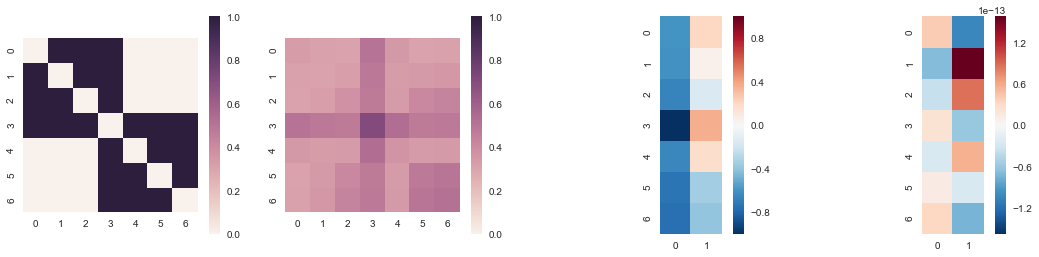

In [22]:
fig=drawing(Xs_iters[0][-1])

In [12]:
def animate(generator, drawing):
    with imageio.get_writer('temp.gif', mode='I') as writer:
        for item in log_progress(generator, every=1):
            fig = drawing(item)
            fig.savefig('temp.png', dpi=72, bbox_inches='tight', pad_inches=0)
            plt.close(fig)
            image = imageio.imread('temp.png')
            writer.append_data(image)
    return Image(url='temp.gif')

In [23]:
animate(Xs_iters[-1][::3], drawing)

NameError: name 'animate' is not defined

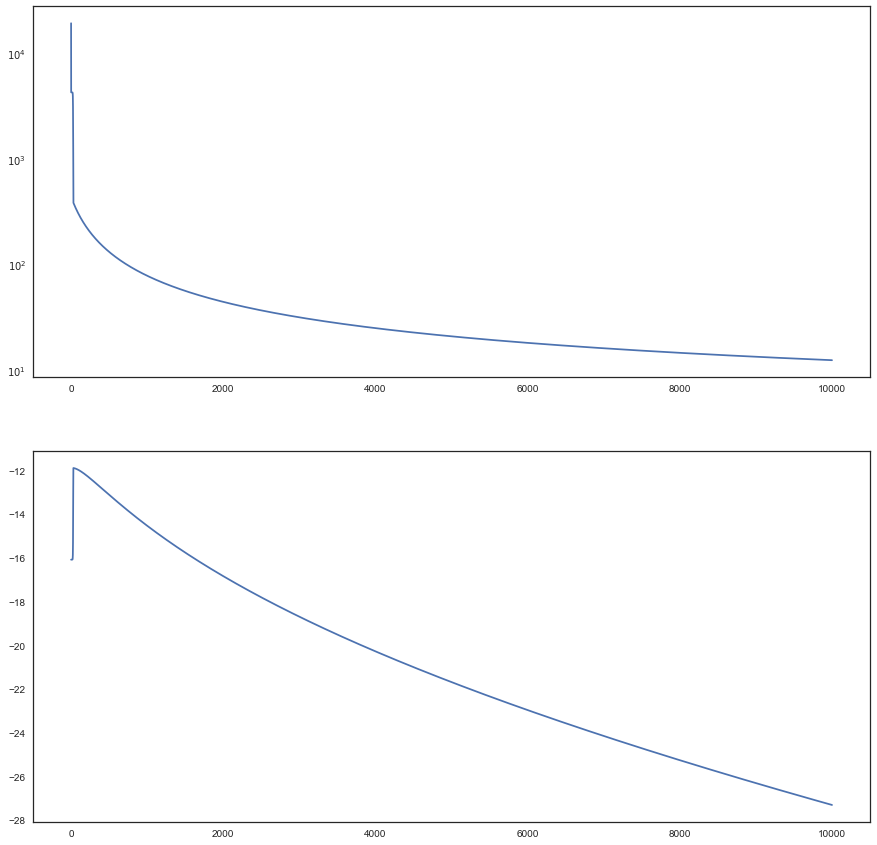

In [33]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(211)
#ax.set_xscale("log")
ax.set_yscale("log")
for norms in norms_iters:
    plt.plot(np.array(norms))
ax = plt.subplot(212)
#ax.set_xscale("log")
#ax.set_yscale("log")
for costs in costs_iters:
    plt.plot(np.array(costs))
#plt.ylim([6,12])

In [59]:
costs_iters[0][-10]

array(-41.65453483140276)

In [20]:
n=7
M = 10
manifold = FixedRankEmbedded(n, n, 2)
problem = Problem(manifold=manifold, cost=se, arg=(U, S, V), verbosity=0)
solver = SteepestDescent(logverbosity=2, minstepsize=1e-40, maxiter=1000)

In [14]:
llh_iters = []
for i in range(M):
    #print(i, end=' ') 
    print i,
    U_init, S_init, V_init = init()
    # let Pymanopt do the rest
    try:
        res = solver.solve(problem, x = (U_init, S_init, V_init))
        Xopt, iters = res[0], res[1]['iterations']
        llh_iters.append(iters)
        #print(res[1]['stoppingreason'])
    except Exception as e:
        print(e)

0 SVD did not converge
1 SVD did not converge
2 3 SVD did not converge
4 5 6 7 8 9 SVD did not converge


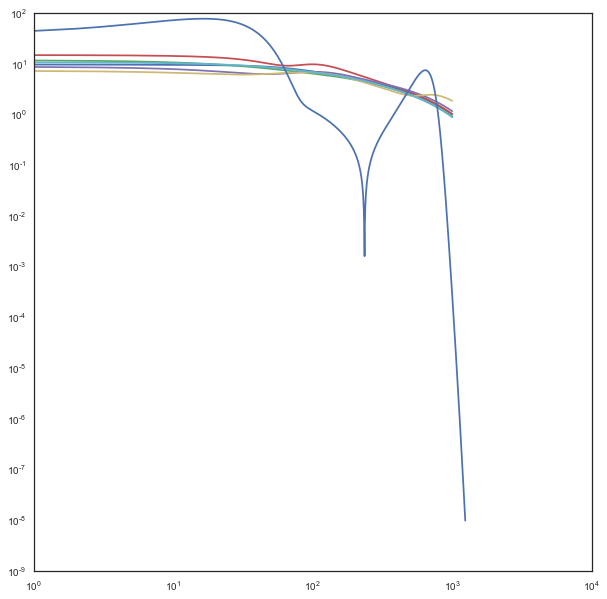

In [17]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.set_xscale("log")
for iters in llh_iters:
    plt.semilogy(np.array(iters['gradnorm']))

#for iters in llh_iters:
plt.semilogy(np.array(norms), )

NameError: name 'Xopt' is not defined

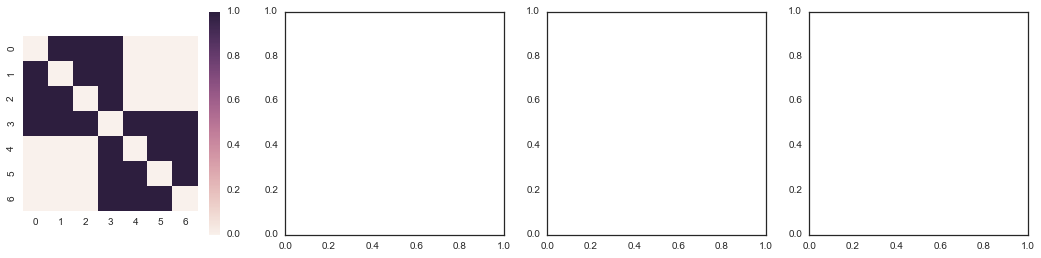

In [24]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=False,)
fig.set_figheight(4)
fig.set_figwidth(18)
sns.heatmap(A.get_value(), ax=ax1, vmin=0, vmax=1, square=True)
sns.heatmap(A_est(Xopt[0], Xopt[1], Xopt[2]), ax=ax2, vmin=0, vmax=1, square=True)
sns.heatmap(Xopt[2].T* np.sqrt(Xopt[1]), ax=ax3, square=True)
sns.heatmap(Xopt[0] - Xopt[2].T, ax=ax4, square=True)

In [ ]:
# U1 = np.array([[1, 1, 0],
#                [0, 1, 1]]).T
# S1 = np.array([1,1])
# V1 = U1.T
# print(U1)
# print()
# print(S1)
# print()
# print(V1)
# print()
# print(loglikelihood(U1, S1, V1))
# print()
# print(loglikelihood_U_grad(U1, S1, V1))

In [4]:
n=7
M = 100
manifold = FixedRankEmbedded(n, n, 2)
problem = Problem(manifold=manifold, cost=-llh, arg=(U, S, V), verbosity=0)
solver = SteepestDescent(logverbosity=2, minstepsize=1e-100)
llh_iters = []
for i in range(M):
    #print(i, end=' ') 
    U_init = np.random.rand(n,2)
    #U_init = np.array([[1,1,1,1,0,0,0],
    #                   [0,0,0,1,1,1,1]]).T + np.random.rand(n,2) * 0.2
    S_init = np.array([0.8,0.9])
    V_init = U_init.T
    # let Pymanopt do the rest
    try:
        res = solver.solve(problem, x = (U_init, S_init, V_init))
        Xopt, iters = res[0], res[1]['iterations']
        llh_iters.append(iters)
    except Exception as e:
        print(e)

0 1 2 3 4 5 6 7 8 SVD did not converge
9 SVD did not converge
10 11 SVD did not converge
12 SVD did not converge
13 SVD did not converge
14 SVD did not converge
15 SVD did not converge
16 SVD did not converge
17 

KeyboardInterrupt: 

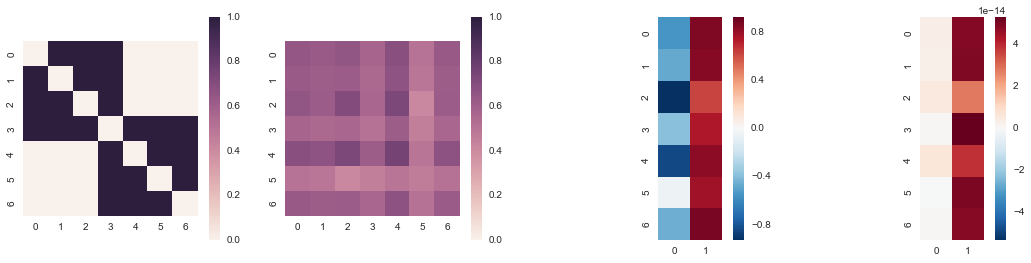

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=False,)
fig.set_figheight(4)
fig.set_figwidth(18)
sns.heatmap(A.get_value(), ax=ax1, vmin=0, vmax=1, square=True)
sns.heatmap(A_est(Xopt[0], Xopt[1], Xopt[2]), ax=ax2, vmin=0, vmax=1, square=True)
sns.heatmap(Xopt[2].T* np.sqrt(Xopt[1]), ax=ax3, square=True)
sns.heatmap(Xopt[0] - Xopt[2].T, ax=ax4, square=True)

In [ ]:
print("======= SOLUTION =======")
FF_est = Xopt[0].dot(np.diag(Xopt[1])).dot(Xopt[2])
print(FF_est)
print()
print(A_est(*Xopt))

In [ ]:
A_est(Xopt[0], Xopt[1], Xopt[2])

In [ ]:
Xopt

In [ ]:
A.get_value()